In [1]:
# glob: ファイルパスのパターンマッチングに使用するモジュール
import glob

# NumPy: 数値計算を効率的に行うためのライブラリ
import numpy as np

# Pandas: データ分析を容易にするためのライブラリ
import pandas as pd

# Matplotlib: グラフ描画のためのライブラリ
import matplotlib.pyplot as plt

# Scikit-learn: 機械学習のためのライブラリ
from sklearn.preprocessing import StandardScaler  # 標準化を行うためのモジュール

# SciPy: 科学技術計算のためのライブラリ
from scipy.signal import savgol_filter  # Savitzky-Golayフィルターを適用するための関数


## <span style="color: DeepPink; ">5.1 スペクトルデータの一括読み込み</span>

### <span style="color: blue; ">スペクトルデータの一括読み込み</span>

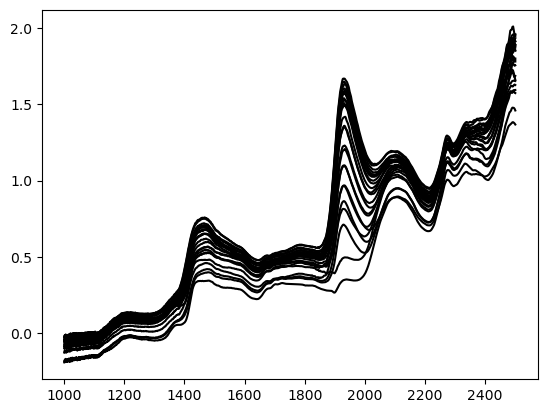

In [2]:
datapath = "./dataChapter5/"  # 読み込むファイルのディレクトリパス
allfiles = glob.glob('{}*.csv'.format(datapath))  #全　CSVファイルのパスをリストとして取得
df_spectra = pd.DataFrame()  # 結合するデータフレームを初期化

# 各CSVファイルに対するループ処理
for file in allfiles:
    df = pd.read_csv(file, header=None)  # ファイルを読み込み
    df_spectra = pd.concat([df_spectra, df.iloc[:, 1]], axis=1)  # 2列目のデータを横方向に結合

df_spectra.columns = range(1, len(allfiles) + 1)  # 列名をファイル数に基づいて設定
df_spectra.index = df.iloc[:, 0]  # インデックスを最初のファイルの最初の列に設定
plt.plot(df_spectra, color='black')  # データフレームを黒色の折れ線グラフで描画
df_spectra = df_spectra.T  # データフレームを転置


## <span style="color: DeepPink; ">5.3.1  中心化と標準化</span>

In [3]:
# StandardScalerを使用
# StandardScalerのインスタンス化
center = StandardScaler(with_std=False) # 中心化（with_stdをfalse）
scaler = StandardScaler() # 標準化

# フィットと変換を同時に行う
df_spectra_centered = center.fit_transform(df_spectra)
df_spectra_scaled = scaler.fit_transform(df_spectra)
# 結果をデータフレームに変換
df_spectra_centered = pd.DataFrame(df_spectra_centered, columns=df_spectra.columns)
df_spectra_scaled = pd.DataFrame(df_spectra_scaled, columns=df_spectra.columns)


#平均スペクトルと標準偏差スペクトルをNumPyで計算
mean_manual = np.mean(df_spectra, axis=0)
std_manual = np.std(df_spectra, axis=0,ddof=0)
df_spectra_centered_manual = df_spectra - mean_manual
df_spectra_scaled_manual = (df_spectra - mean_manual) / std_manual

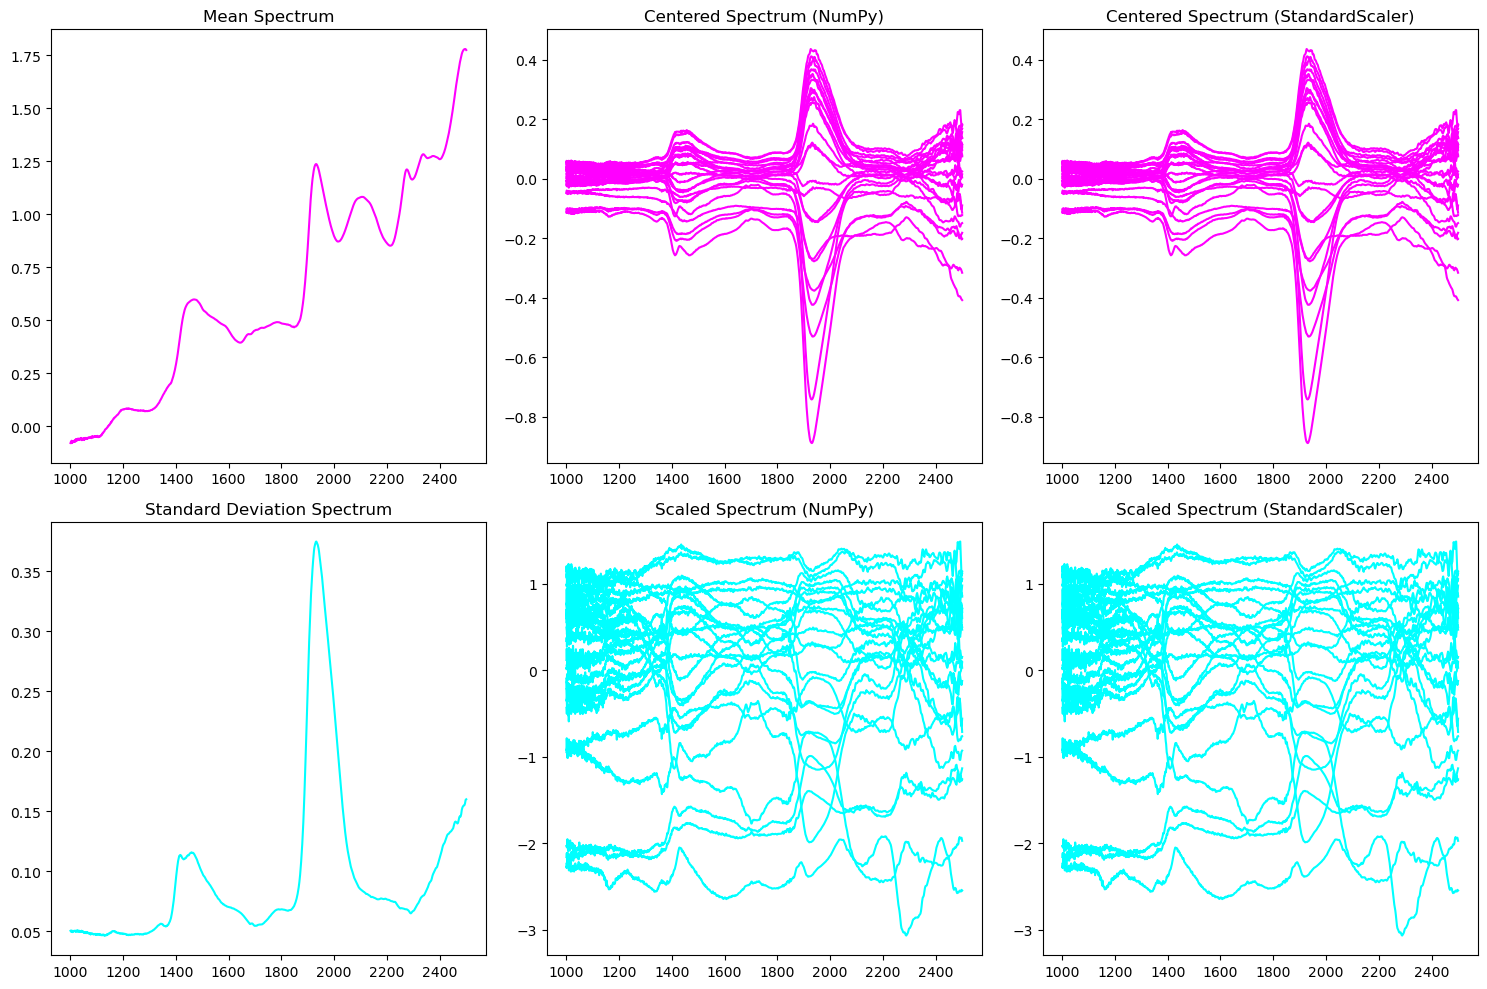

In [4]:
# サブプロットの作成
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 平均スペクトルのプロット（位置：1,1）
axes[0, 0].plot(mean_manual, color='magenta')
axes[0, 0].set_title('Mean Spectrum')

# 標準偏差スペクトルのプロット（位置：2,1）
axes[1, 0].plot(std_manual, color='cyan')
axes[1, 0].set_title('Standard Deviation Spectrum')

# 中心化されたスペクトルをNumpyで計算したプロット（位置：1,2）
axes[0, 1].plot(df_spectra_centered_manual.T, color='magenta')
axes[0, 1].set_title('Centered Spectrum (NumPy)')

# 標準化されたスペクトルをNumpyで計算したプロット（位置：2,2）
axes[1, 1].plot(df_spectra_scaled_manual.T, color='cyan')
axes[1, 1].set_title('Scaled Spectrum (NumPy)')

# 中心化されたスペクトルのStandardScaler版のプロット（位置：1,3）
axes[0, 2].plot(df_spectra_centered.T, color='magenta')
axes[0, 2].set_title('Centered Spectrum (StandardScaler)')

# 標準化されたスペクトルのStandardScaler版のプロット（位置：2,3）
axes[1, 2].plot(df_spectra_scaled.T, color='cyan')
axes[1, 2].set_title('Scaled Spectrum (StandardScaler)')

# グラフを表示
plt.tight_layout()
plt.show()

## <span style="color: DeepPink; ">5.3.2乗算的散乱補正(MSC, multiplicative scattering correction)</span>

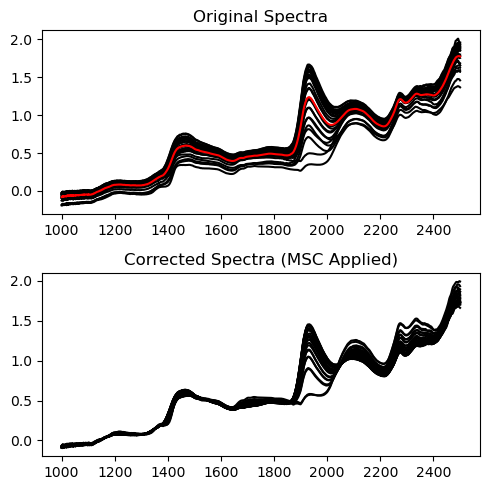

In [5]:
# df_spectraの平均スペクトルを計算
mean_spectrum = df_spectra.mean()
# MSを行う関数の定義
def apply_msc(sample, reference):
    # 傾きと切片を計算
    fit = np.polyfit(reference, sample, 1, full=True)
    slope = fit[0][0]
    intercept = fit[0][1]
    # スペクトルの修正
    return (sample - intercept) / slope

# df_spectraの各スペクトルにMSCを適用し、新しいDataFrameに保存
df_spectra_msc = df_spectra.apply(lambda x: apply_msc(x, mean_spectrum), axis=1)


# 指定されたプロットを作成するためのコード
fig, axes = plt.subplots(2, 1, figsize=(5, 5))

# 元のスペクトルをプロット
axes[0].plot(df_spectra.T, color='black')
axes[0].plot(mean_spectrum.T, color='red')
axes[0].set_title('Original Spectra')
# 修正されたスペクトル（MSC後）をプロット
axes[1].plot(df_spectra_msc.T, color='black')
axes[1].set_title('Corrected Spectra (MSC Applied)')

plt.tight_layout()
plt.show()

## <span style="color: DeepPink; ">5.4.2　スムージング、1次微分、2次微分スペクトルの実行</span>

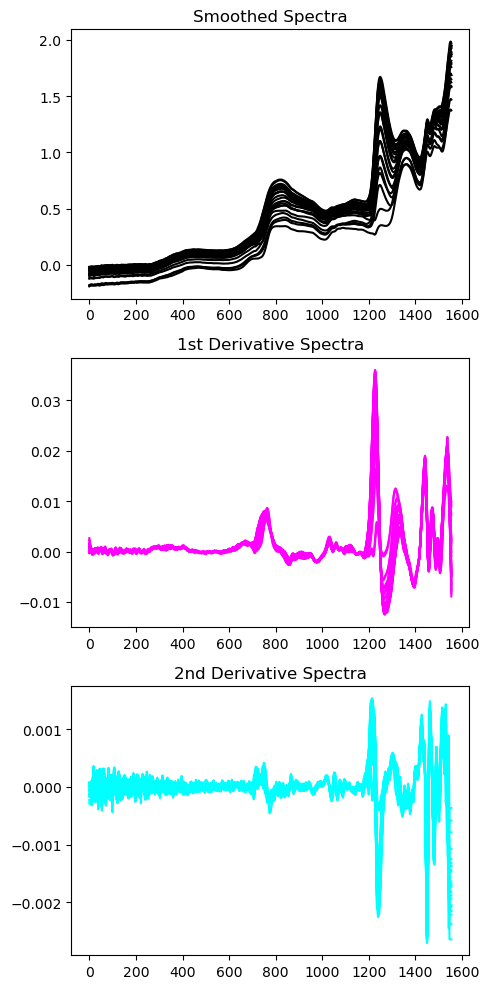

In [6]:
window_size = 17 # スムージングポイント
poly_order = 2 # 近似する多項式の次数
# savgol_filterによるフィルタ処理
df_spectra_sg_smooth = savgol_filter(df_spectra, window_size, poly_order, axis=1)
df_spectra_sg_1st = savgol_filter(df_spectra, window_size, poly_order, deriv=1, axis=1)
df_spectra_sg_2nd = savgol_filter(df_spectra, window_size, poly_order, deriv=2, axis=1)

fig, axes = plt.subplots(3, 1, figsize=(5, 10))
axes[0].plot(df_spectra_sg_smooth.T, color='black')
axes[0].set_title('Smoothed Spectra')
axes[1].plot(df_spectra_sg_1st.T, color='magenta')
axes[1].set_title('1st Derivative Spectra')
axes[2].plot(df_spectra_sg_2nd.T, color='cyan')
axes[2].set_title('2nd Derivative Spectra')
plt.tight_layout()
plt.show()

## <span style="color: DeepPink; ">5.4.3　SNVの実行</span>

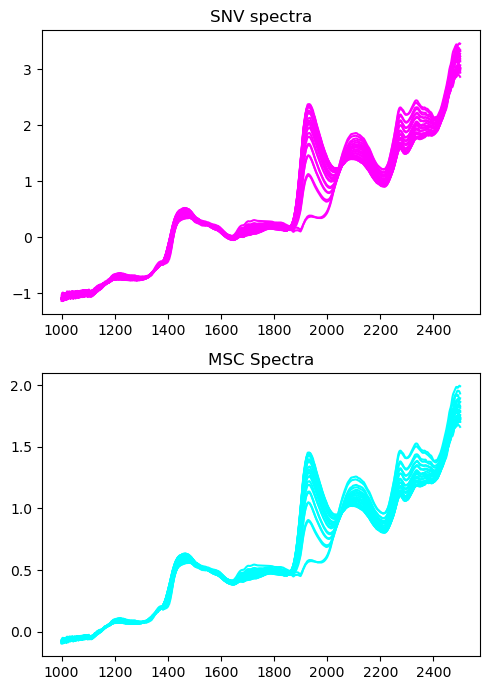

In [8]:
def snv(input_data):
    # 各スペクトルから平均を引いて標準偏差で割る
    return (input_data - input_data.mean()) / input_data.std()
# DataFrameの各行（各試料）にSNVを適用
df_spectra_snv = df_spectra.apply(snv, axis=1)


fig, axes = plt.subplots(2, 1, figsize=(5, 7))
axes[0].plot(df_spectra_snv.T,color='magenta')
axes[0].set_title('SNV spectra')
axes[1].plot(df_spectra_msc.T, color='cyan')
axes[1].set_title('MSC Spectra')
plt.tight_layout()
plt.show()